# Tutorial 7d - Three Mirror Anastigmat (TMA)

This tutorial aims at demonstrating Optiland's capabilities in reflective systems design using freeform mirrors.

### Setup the telescope

The starting telescope is voluntarily defocused, it will be optimized after.

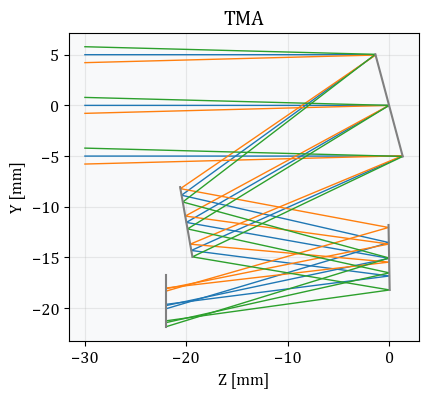

╒════╤═══════════════════════════╤══════════╤═════════════╤════════════╤═════════╤═════════════════╕
│    │ Type                      │   Radius │   Thickness │ Material   │   Conic │   Semi-aperture │
╞════╪═══════════════════════════╪══════════╪═════════════╪════════════╪═════════╪═════════════════╡
│  0 │ Planar                    │      inf │         inf │ Air        │       0 │         5       │
│  1 │ Stop - Zernike Polynomial │     -100 │         -20 │ Mirror     │       0 │         5       │
│  2 │ Zernike Polynomial        │     -100 │          20 │ Mirror     │       0 │         3.52372 │
│  3 │ Zernike Polynomial        │     -100 │         -22 │ Mirror     │       0 │        12.6569  │
│  4 │ Planar                    │      inf │         nan │ Air        │       0 │         3.9344  │
╘════╧═══════════════════════════╧══════════╧═════════════╧════════════╧═════════╧═════════════════╛


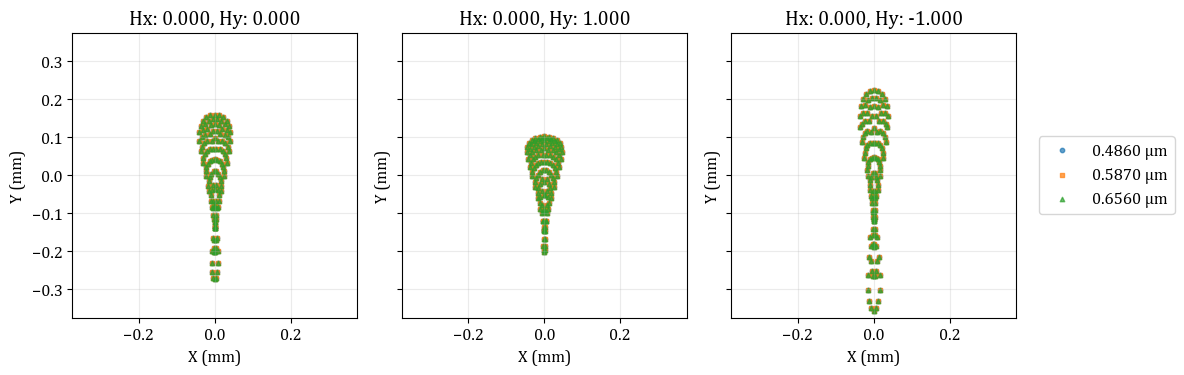

In [1]:
import numpy as np

from optiland import analysis, optic, optimization

focal_length = 100  # [mm]

lens = optic.Optic(name="TMA")
lens.set_aperture(aperture_type="EPD", value=10)
lens.set_field_type(field_type="angle")
lens.add_field(y=0)
lens.add_field(y=+1.5)
lens.add_field(y=-1.5)
lens.add_wavelength(value=0.486)
lens.add_wavelength(value=0.587, is_primary=True)
lens.add_wavelength(value=0.656)

# The telescope is made of three freeform surfaces (Zernike)
lens.add_surface(index=0, radius=np.inf, thickness=np.inf)
lens.add_surface(
    index=1,
    radius=-100,
    thickness=-20,
    conic=0,
    material="mirror",
    rx=np.radians(-15.0),
    is_stop=True,
    surface_type="zernike",
    coefficients=[],
)
lens.add_surface(
    index=2,
    radius=-100,
    thickness=+20,
    conic=0,
    material="mirror",
    rx=np.radians(-10.0),
    dy=-11.5,
    surface_type="zernike",
    coefficients=[],
)
lens.add_surface(
    index=3,
    radius=-100,
    thickness=-22,
    conic=0,
    material="mirror",
    rx=np.radians(-1.0),
    dy=-15,
    surface_type="zernike",
    coefficients=[],
)
lens.add_surface(index=4, dy=-19.3)

lens.update_paraxial()
lens.draw(title=lens.name)
lens.info()
# lens.draw3D()
spot = analysis.SpotDiagram(lens)
spot.view()

## Optimization

The optimization variables are the radii, thicknesses, decenters & tilts, and the freeform coefficients.

We define contraints on the mirrors' decenters to prevent vignetting.

### Variables

In [2]:
problem = optimization.OptimizationProblem()

# radii
problem.add_variable(lens, "radius", surface_number=1, min_val=-1000, max_val=1000)
problem.add_variable(lens, "radius", surface_number=2, min_val=-1000, max_val=1000)
problem.add_variable(lens, "radius", surface_number=3, min_val=-1000, max_val=1000)

# thicknesses
problem.add_variable(lens, "thickness", surface_number=1, min_val=-35, max_val=-15)
problem.add_variable(lens, "thickness", surface_number=2, min_val=+15, max_val=+35)
problem.add_variable(lens, "thickness", surface_number=3, min_val=-35, max_val=-15)

# decenters
problem.add_variable(
    lens,
    "decenter",
    axis="y",
    surface_number=2,
    min_val=-15,
    max_val=-10,
)
problem.add_variable(
    lens,
    "decenter",
    axis="y",
    surface_number=3,
    min_val=-20,
    max_val=-11,
)
problem.add_variable(
    lens,
    "decenter",
    axis="y",
    surface_number=4,
    min_val=-28,
    max_val=-22,
)

# tilts
problem.add_variable(
    lens,
    "tilt",
    axis="x",
    surface_number=1,
    min_val=np.radians(-20.0),
    max_val=np.radians(-12.0),
)
problem.add_variable(
    lens,
    "tilt",
    axis="x",
    surface_number=2,
    min_val=np.radians(-15.0),
    max_val=np.radians(-08.0),
)
problem.add_variable(
    lens,
    "tilt",
    axis="x",
    surface_number=3,
    min_val=np.radians(-10.0),
    max_val=np.radians(+10.0),
)

# conic constants
problem.add_variable(lens, "conic", surface_number=1, min_val=-10, max_val=10)
problem.add_variable(lens, "conic", surface_number=2, min_val=-10, max_val=10)
problem.add_variable(lens, "conic", surface_number=3, min_val=-10, max_val=10)

# Freeform coefficients
for s in range(1, 4):
    for i in range(4):
        problem.add_variable(
            lens,
            "zernike_coeff",
            surface_number=s,
            coeff_index=i,
            min_val=-1,
            max_val=1,
        )

### Operands

In [ ]:
# Center M2 on its chief ray
input_data = {
    "optic": lens,
    "surface_number": 2,
    "Hx": 0,
    "Hy": 0,
    "Px": 0,
    "Py": 0,
    "wavelength": lens.wavelengths.primary_wavelength.value,
}
problem.add_operand(
    operand_type="real_y_intercept_lcs",
    target=0.0,
    weight=1,
    input_data=input_data,
)

# Center M3 on its chief ray
input_data = {
    "optic": lens,
    "surface_number": 3,
    "Hx": 0,
    "Hy": 0,
    "Px": 0,
    "Py": 0,
    "wavelength": lens.wavelengths.primary_wavelength.value,
}
problem.add_operand(
    operand_type="real_y_intercept_lcs",
    target=0.0,
    weight=1,
    input_data=input_data,
)

# Image surface - Real ray heights operands, in the lcs of the image surface
# Center the image surface on its chief ray
input_data = {
    "optic": lens,
    "surface_number": 4,
    "Hx": 0,
    "Hy": 0,
    "Px": 0,
    "Py": 0,
    "wavelength": lens.wavelengths.primary_wavelength.value,
}
problem.add_operand(
    operand_type="real_y_intercept_lcs",
    target=focal_length * np.tan(np.deg2rad(lens.fields.y_fields[0])),
    weight=1,
    input_data=input_data,
)
input_data = {
    "optic": lens,
    "surface_number": 4,
    "Hx": 0,
    "Hy": 1,
    "Px": 0,
    "Py": 0,
    "wavelength": lens.wavelengths.primary_wavelength.value,
}
problem.add_operand(
    operand_type="real_y_intercept_lcs",
    target=focal_length * np.tan(np.deg2rad(lens.fields.y_fields[1])),
    weight=1,
    input_data=input_data,
)
input_data = {
    "optic": lens,
    "surface_number": 4,
    "Hx": 0,
    "Hy": -1,
    "Px": 0,
    "Py": 0,
    "wavelength": lens.wavelengths.primary_wavelength.value,
}
problem.add_operand(
    operand_type="real_y_intercept_lcs",
    target=focal_length * np.tan(np.deg2rad(lens.fields.y_fields[2])),
    weight=1,
    input_data=input_data,
)

# RMS spot size - let's minimize the spot size for each field at the primary wavelength.
# We choose a 'uniform' distribution, so the number of rays actually means the rays on
# one axis. Therefore we trace ≈16^2 rays here.
for field in lens.fields.get_field_coords():
    input_data = {
        "optic": lens,
        "surface_number": 4,
        "Hx": field[0],
        "Hy": field[1],
        "num_rays": 16,
        "wavelength": 0.587,
        "distribution": "uniform",
    }
    problem.add_operand(
        operand_type="rms_spot_size",
        target=0.0,
        weight=10,
        input_data=input_data,
    )

problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                6.19557 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤══════════════════════╤══════════╤═════════════╤═════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type         │   Target │ Min Bound   │ Max Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪══════════════════════╪══════════╪═════════════╪═════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ real y intercept lcs │    0     │             │             │        1 │  -0.043 │  -0.043 │           0.03 │
│  1 │ real y intercept lcs │    0     │             │             │        1 │  -0.086 │  -0.086 │           0.12 │
│  2 │ real y intercept lcs │    0     │             │             │        1 │  -0.443 │  -0.443 │           3.17 │
│  3 │ real y intercept lcs │    2.619

### Optimization

╒════╤═══════════════════════════╤══════════╤═════════════╤════════════╤══════════════╤═════════════════╕
│    │ Type                      │   Radius │   Thickness │ Material   │        Conic │   Semi-aperture │
╞════╪═══════════════════════════╪══════════╪═════════════╪════════════╪══════════════╪═════════════════╡
│  0 │ Planar                    │  inf     │    inf      │ Air        │  0           │         5       │
│  1 │ Stop - Zernike Polynomial │ -126.089 │    -30.3923 │ Mirror     │ -0.0117211   │         5       │
│  2 │ Zernike Polynomial        │ -101.251 │     25.9284 │ Mirror     │  2.29e-05    │         3.38547 │
│  3 │ Zernike Polynomial        │ -152.841 │    -28.926  │ Mirror     │ -0.000157152 │        15.4754  │
│  4 │ Planar                    │  inf     │    nan      │ Air        │  0           │        11.6735  │
╘════╧═══════════════════════════╧══════════╧═════════════╧════════════╧══════════════╧═════════════════╛


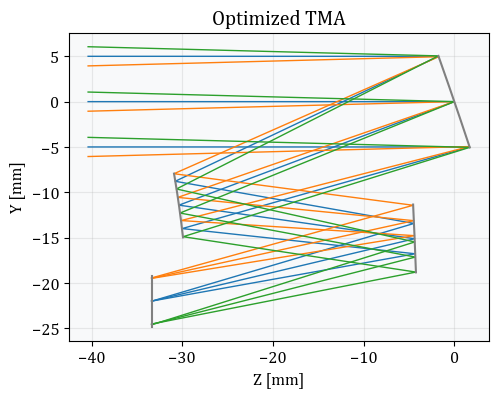

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │               0.154056 │           97.5134 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤══════════════════════╤══════════╤═════════════╤═════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type         │   Target │ Min Bound   │ Max Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪══════════════════════╪══════════╪═════════════╪═════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ real y intercept lcs │    0     │             │             │        1 │   0.033 │   0.033 │           0.72 │
│  1 │ real y intercept lcs │    0     │             │             │        1 │  -0.026 │  -0.026 │           0.45 │
│  2 │ real y intercept lcs │    0     │             │             │        1 │   0.013 │   0.013 │           0.12 │
│  3 │ real y intercept lcs │    2.619

In [4]:
# Local optimizer
optimizer = optimization.OptimizerGeneric(problem)
res = optimizer.optimize(tol=1e-9)

# Global optimizer
# optimizer = optimization.DifferentialEvolution(problem)
# res = optimizer.optimize(maxiter=100, workers=-1)

lens.info()
lens.draw(title=f"Optimized {lens.name}")
problem.info()

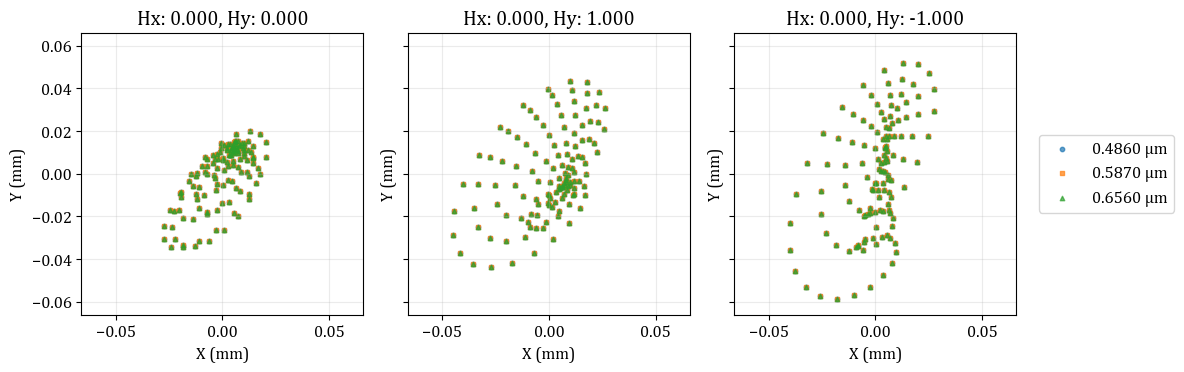

In [7]:
spot = analysis.SpotDiagram(lens)
spot.view()

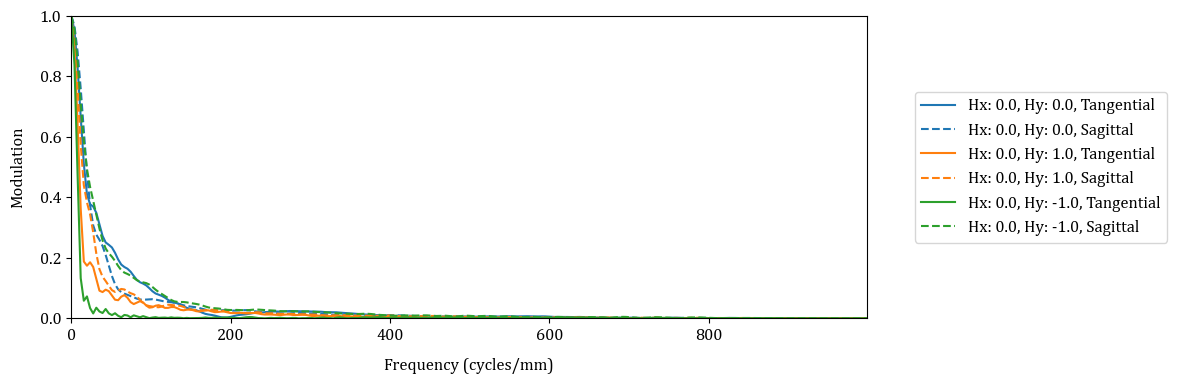

In [8]:
from optiland.mtf import GeometricMTF

geo_mtf = GeometricMTF(lens)
geo_mtf.view()